# **EJ 3: Previsión de fallas**

Realización: Mariano Iván Rojas Flores

A continuación se presenta la resolución del ejercicio 3 del desafío de Mercado Libre.

En este ejercicio se solicita realizar un modelo predictivo para determinar la probabilidad de falla de dispositivos de Full con el objetivo de bajar los costos del mantenimiento preventivo.

Los resultados se estructuran de la siguiente manera

1) Visualización preliminar y limpieza de los datos.  
      
      1a) Importación de librerías y archivo
      1b) Visualización preliminar de los datos (item informativo)  
      1c) Limpieza de los datos  
      1d) Búsqueda inicial de patrones (item informativo)
      1e) Escalado y separación de set de entrenmianto y de prueba


2) Búsqueda del mejor modelo de predicción.

3) Selección de hiperparámetros del modelo elegido.

4) Evaluación final de performance del modelo.

5) Conclusiones

## **1) VISUALIZACIÓN PRELIMINAR Y LIMPIEZA DE DATOS**

En este item importamos el archivo de datos, revisamos su contenido, limpiamos las filas y columnas que no necesitamos y buscamos patrones entre los atributos para seleccionarlos.

# 1a) IMPORTACIÓN DE LIBRERÍAS Y ARCHIVO DE DATOS


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, precision_score, recall_score
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
import joblib




In [2]:
file_path = "/content/full_devices.csv"
data = pd.read_csv(file_path, encoding='ISO-8859-1')


# 1b) VISUALIZACIÓN PRELIMINAR DE LOS DATOS (informativa)

Esta parte es meramente informativa, para ver la estructura de los datos y el tipo de información con la que se cuenta. Puede omitirse

Primeras filas de la tabla

In [3]:
data.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


Dimensiones de la tabla y Tipos de datos de las columnas

In [4]:
print("Dimensiones del DataFrame:", data.shape)

print("\n Columnas y tipos de datos")
print(data.dtypes)

Dimensiones del DataFrame: (124494, 12)

 Columnas y tipos de datos
date          object
device        object
failure        int64
attribute1     int64
attribute2     int64
attribute3     int64
attribute4     int64
attribute5     int64
attribute6     int64
attribute7     int64
attribute8     int64
attribute9     int64
dtype: object


Información de las columnas numéricas

In [5]:
data.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


Se cuentan los registros duplicados (ya que esta parte es solo de visualización, se eliminarán algunas celdas más adelante)

In [6]:
print("Registros Duplicados:", data.duplicated().sum())

Registros Duplicados: 1


Evaluación del balance de la información.  
Se cuentan cuántos registros hay sobre estados de condición normal y cuántos hay de estados de falla.

In [7]:
#Proporción de 1 y 0 en la variable objetivo "Failure"

failure_counts = data['failure'].value_counts()
print("Cantidad de ceros (sin fallas):", failure_counts[0])
print("Cantidad de unos (con fallas):", failure_counts[1])

failure_percentages = data['failure'].value_counts(normalize=True) *100
print("Porcentaje de ceros (sin fallas):", failure_percentages[0], "%")
print("Porcentaje de unos (con fallas):", failure_percentages[1], "%")

Cantidad de ceros (sin fallas): 124388
Cantidad de unos (con fallas): 106
Porcentaje de ceros (sin fallas): 99.91485533439362 %
Porcentaje de unos (con fallas): 0.0851446656063746 %


Se cuentan la cantidad de valores únicos por columna, para tomar dimensión de la variabilidad de los datos.

In [8]:
unique_counts_df = data.nunique().reset_index()
unique_counts_df.columns = ['Columna', 'Valores Únicos']

print("Cantidad de valores únicos por columna:")
print(unique_counts_df)

Cantidad de valores únicos por columna:
       Columna  Valores Únicos
0         date             304
1       device            1169
2      failure               2
3   attribute1          123877
4   attribute2             558
5   attribute3              47
6   attribute4             115
7   attribute5              60
8   attribute6           44838
9   attribute7              28
10  attribute8              28
11  attribute9              65


A partir de la visualización de carcterísticas generales de las columnas podemos inferir que los atributos 7 y 8 son iguales, por lo que vamos a chequear si efectivamente lo son.  
Si es así, se eliminará más adelante la columna de atributo 8 para ahorrar gasto computacional innecesario.

In [9]:
are_equal = data['attribute7'].equals(data['attribute8'])

if are_equal:
    print("Las columnas 'attribute7' y 'attribute8' son iguales.")
else:
    print("Las columnas 'attribute7' y 'attribute8' son diferentes.")

Las columnas 'attribute7' y 'attribute8' son iguales.


# 1c) LIMPIEZA DE LOS DATOS

En esta sección se elimina el registro duplicado, se elimina la columna de 'attribute8' y se transforma la columna 'date' al tipo datetime.

In [10]:
data = data.drop_duplicates(keep='first').reset_index(drop=True) # Se eliminan duplicados y se reinicia el índice
data['date'] = pd.to_datetime(data['date']) # Transformamos 'date' a tipo datetime
data = data.drop(columns=['attribute8']) # Se elimina el atributo 8 por ser redundante

print("\nLonmgitud del DataFrame luego de eliminar duplicados:", len(data))

data.head()


Lonmgitud del DataFrame luego de eliminar duplicados: 124493


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3


# 1d) BÚSQUEDA INICIAL DE PATRONES (informativa)

En este apartado se realizan algunos gráficos para visualizar la distribución de los atributos, y su posible influencia en la falla de los artefactos.

(No se calculan variables que afecten al esquema central del modelo, por lo que puede omitirse)

Promedio de duración de dispositivos que fallaron al menos una vez: 107 días
Promedio de duración de dispositivos que nunca fallaron: 112 días


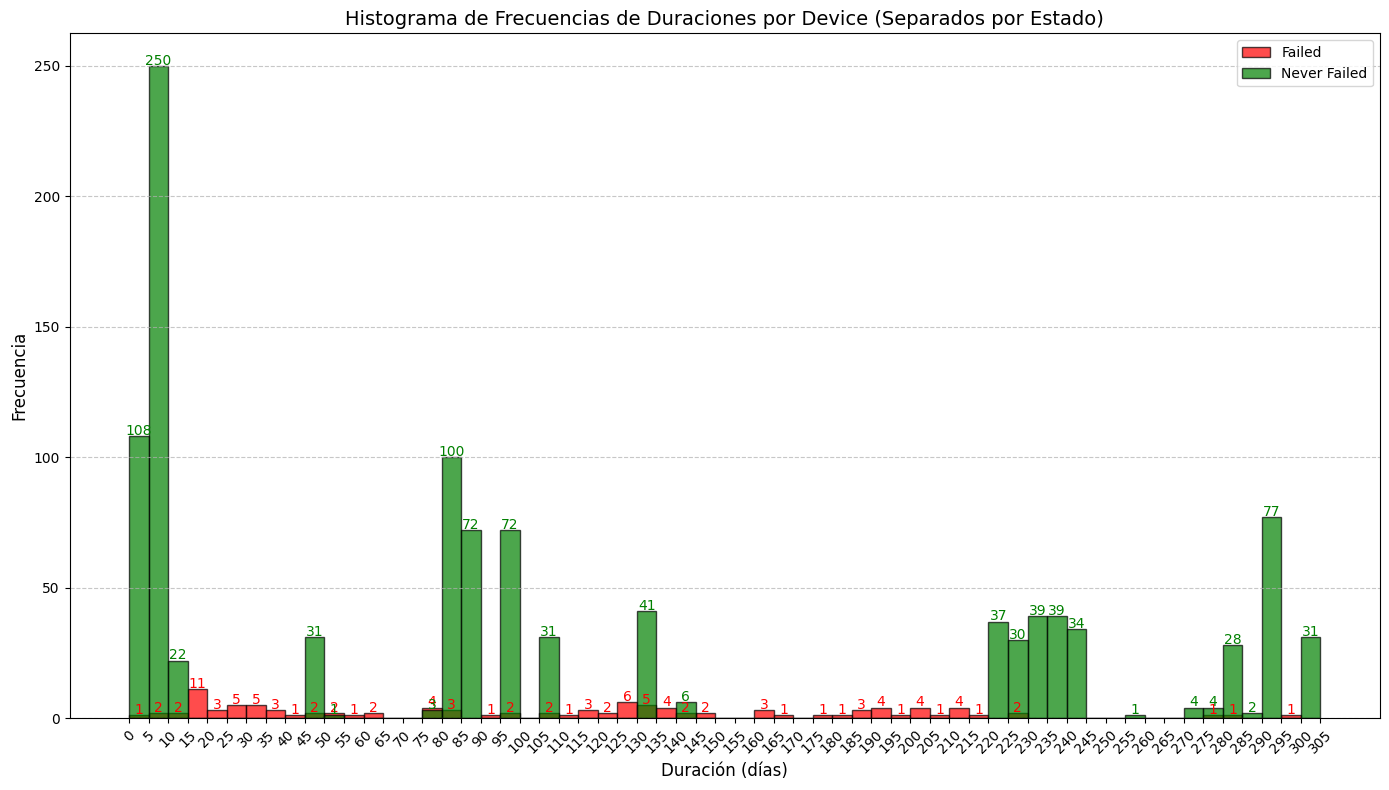

In [11]:
# Separar dispositivos que fallaron al menos una vez y los que no fallaron nunca
devices_failure = data[data['failure'] == 1]['device'].unique()
failure_data = data.copy()
failure_data['failure_status'] = failure_data['device'].apply(lambda x: 'Failed' if x in devices_failure else 'Never Failed')

# Calcular la duración en días por device para cada grupo
durations = failure_data.groupby(['device', 'failure_status'])['date'].agg(lambda x: (x.max() - x.min()).days).reset_index()
durations.columns = ['device', 'failure_status', 'duration_days']

# Dividir en dispositivos que fallaron y que no fallaron
durations_failed = durations[durations['failure_status'] == 'Failed']
durations_never_failed = durations[durations['failure_status'] == 'Never Failed']

# Calcular el promedio de duración para cada grupo
average_duration_failed = durations_failed['duration_days'].mean()
average_duration_never_failed = durations_never_failed['duration_days'].mean()

# Mostrar los promedios
print(f"Promedio de duración de dispositivos que fallaron al menos una vez: {average_duration_failed:.0f} días")
print(f"Promedio de duración de dispositivos que nunca fallaron: {average_duration_never_failed:.0f} días")

# Crear histogramas de frecuencias para cada grupo
plt.figure(figsize=(14, 8))
bins = np.arange(durations['duration_days'].min(), durations['duration_days'].max() + 5, 5)

# Histograma para dispositivos que fallaron
plt.hist(durations_failed['duration_days'], bins=bins, color='red', alpha=0.7, label='Failed', edgecolor='black')
# Histograma para dispositivos que nunca fallaron
plt.hist(durations_never_failed['duration_days'], bins=bins, color='green', alpha=0.7, label='Never Failed', edgecolor='black')

# Mostrar valores sobre cada barra para los dispositivos que fallaron
hist_failed, bin_edges_failed, _ = plt.hist(durations_failed['duration_days'], bins=bins, alpha=0)
for i, value in enumerate(hist_failed):
    if value > 0:
        plt.text(bin_edges_failed[i] + 2.5, value + 0.5, int(value), ha='center', fontsize=10, color='red')

# Mostrar valores sobre cada barra para los dispositivos que no fallaron
hist_never_failed, bin_edges_never_failed, _ = plt.hist(durations_never_failed['duration_days'], bins=bins, alpha=0)
for i, value in enumerate(hist_never_failed):
    if value > 0:
        plt.text(bin_edges_never_failed[i] + 2.5, value + 0.5, int(value), ha='center', fontsize=10, color='green')

# Configuración del gráfico
plt.title("Histograma de Frecuencias de Duraciones por Device (Separados por Estado)", fontsize=14)
plt.xlabel("Duración (días)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(bins, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Con este gráfico podemos ver que la duración promedio de los artefactos es de aproximadamente 107 días, pero que es un valor sumamente variable, habiendo algunos que duran sólo 5 días y otros que duran casi 300.

A contninuación se presentan una especie de histogramas de frecuencias para todos los atributos, sólo que en lugar de colocarse la frecuencia absoluta, se coloca en porcentaje respecto al total de su clase.  
En cada histograma se muestran los valores de clase 0 en verde, los de clase 1 en rojo y la superposición de clases en naranja.  
A la izquierda se presentan en escala normal y a la derecha en escala logarítmica, para visualizar mejor los casos donde hay una frecuencias muy dominantes.



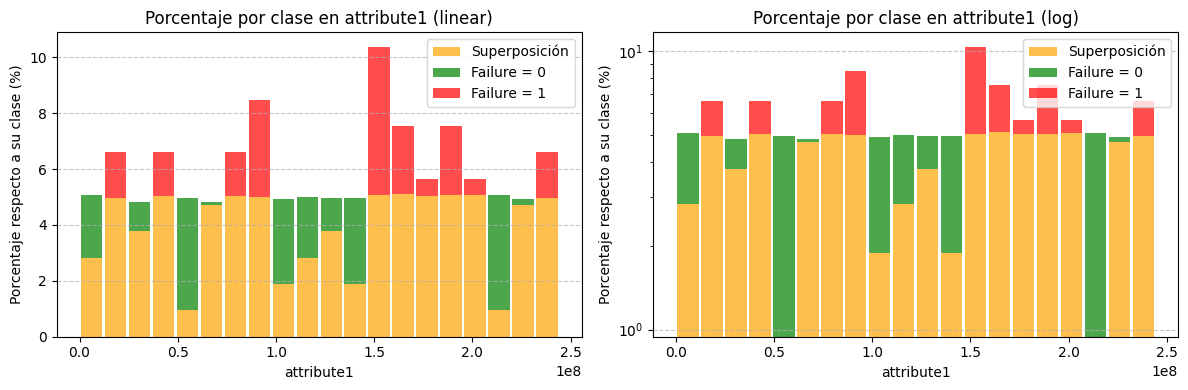

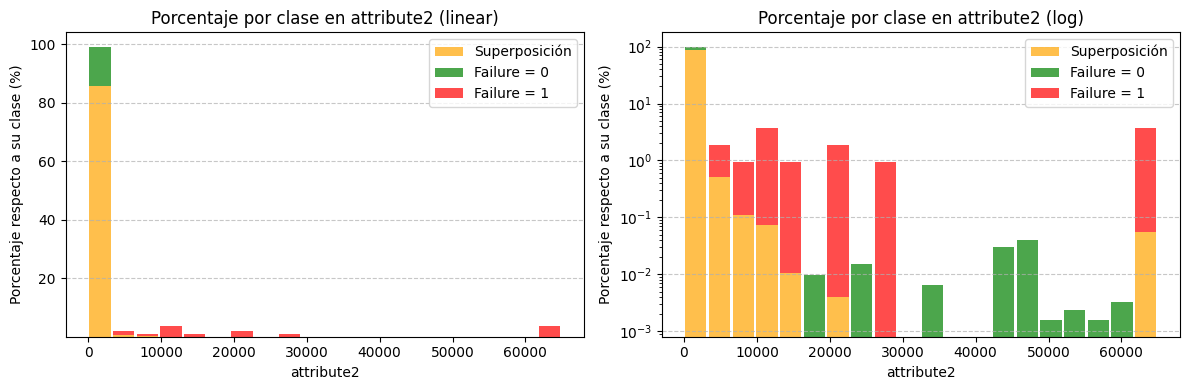

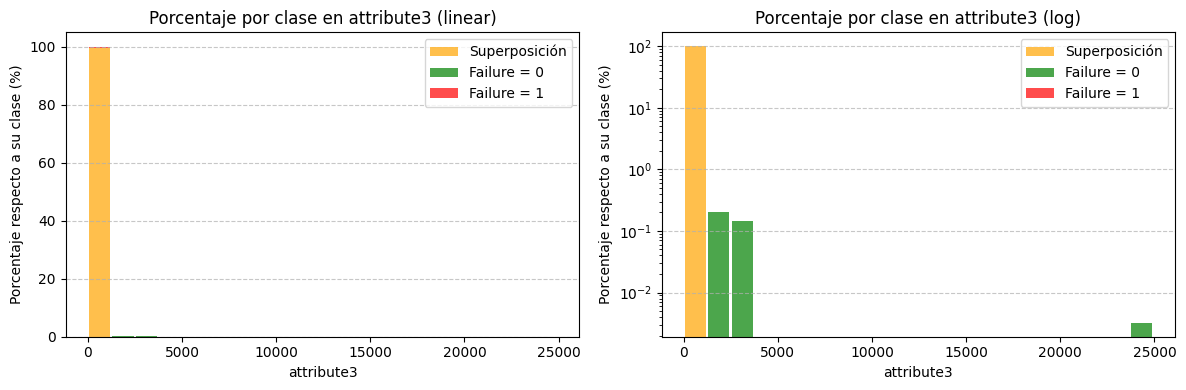

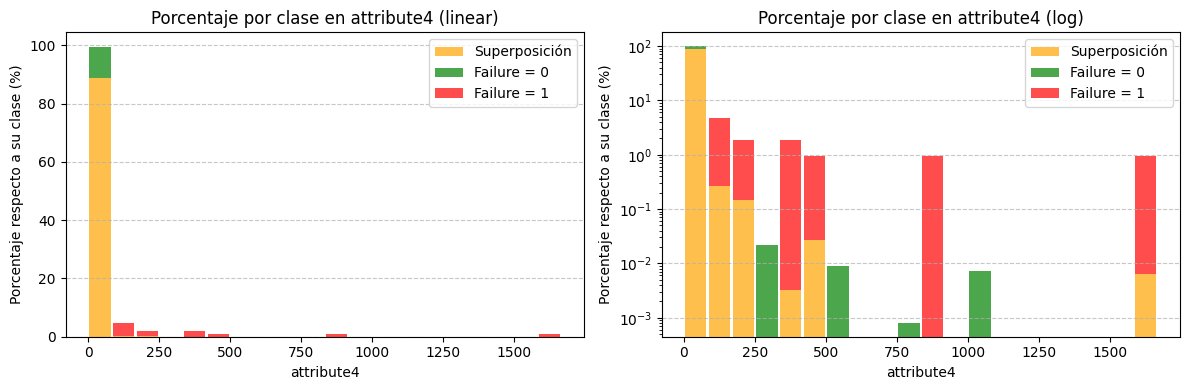

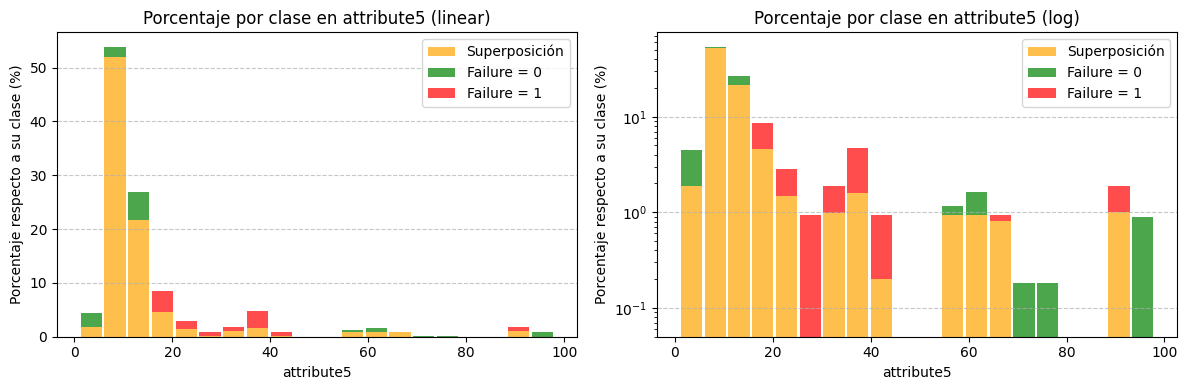

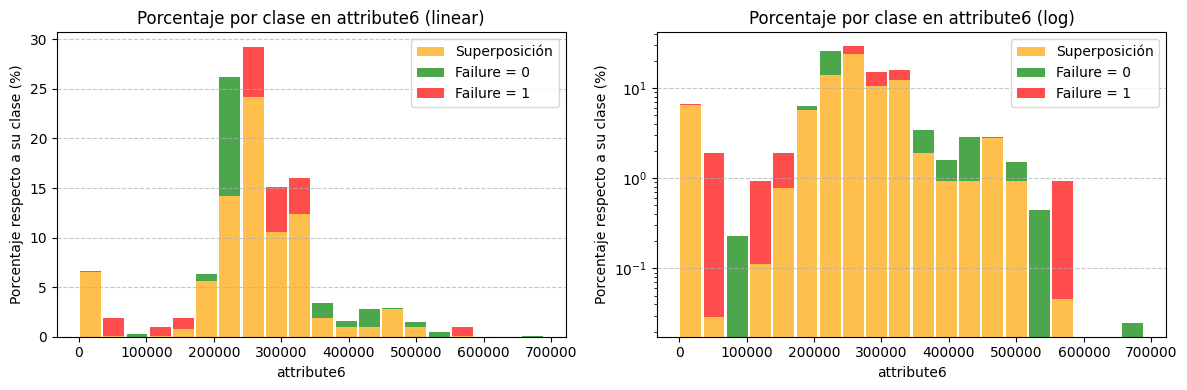

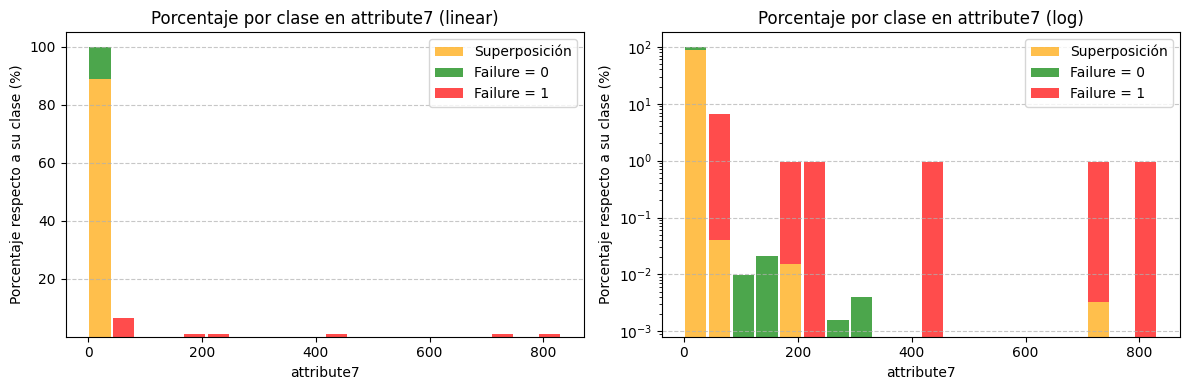

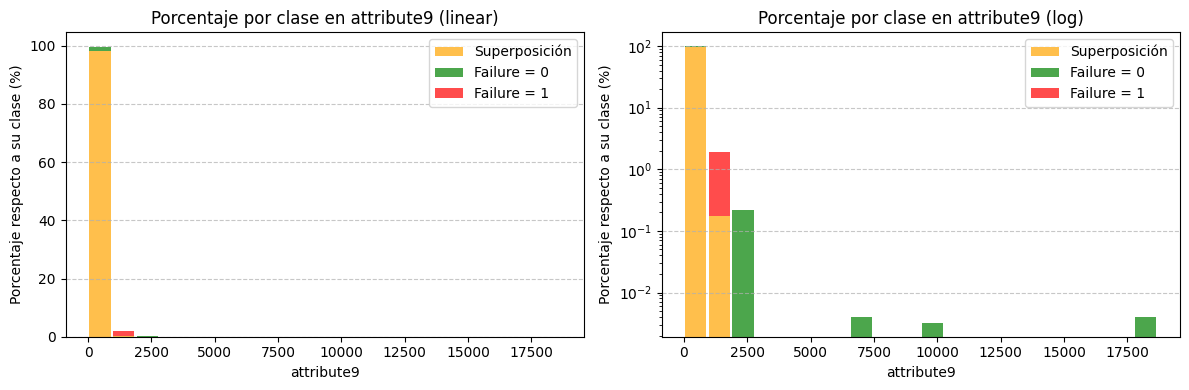

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Crear histogramas comparativos para todas las columnas
for column in data.columns:
    if column not in ['failure', 'date', 'device']:  # Excluir las columnas no numéricas
        # Crear una figura con dos subplots (izquierda: escala normal, derecha: escala logarítmica)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Preparar datos para histogramas con porcentajes respecto al total de su clase
        data_0 = data[data['failure'] == 0][column]
        data_1 = data[data['failure'] == 1][column]

        bins = np.histogram_bin_edges(data[column], bins=20)  # Usar 20 bins
        hist_0, _ = np.histogram(data_0, bins=bins)
        hist_1, _ = np.histogram(data_1, bins=bins)

        total_0 = len(data_0)  # Total de registros clase 0
        total_1 = len(data_1)  # Total de registros clase 1

        percent_0 = (hist_0 / total_0) * 100
        percent_1 = (hist_1 / total_1) * 100

        # Manejo de NaN en porcentajes para evitar errores
        percent_0 = np.nan_to_num(percent_0)
        percent_1 = np.nan_to_num(percent_1)

        # Crear barras con superposición y colores
        bar_width = (bins[1] - bins[0]) * 0.9  # Ajustar el ancho de las barras
        x_positions = bins[:-1] + (bins[1] - bins[0]) / 2

        # Cálculo de la superposición y las diferencias
        overlap = np.minimum(percent_0, percent_1)
        excess_0 = percent_0 - overlap
        excess_1 = percent_1 - overlap

        for ax, scale in zip(axes, ['linear', 'log']):
            # Graficar la superposición en naranja
            ax.bar(x_positions, overlap, width=bar_width, color='orange', alpha=0.7, label='Superposición')

            # Graficar el exceso de cada clase por encima de la superposición
            ax.bar(x_positions, excess_0, width=bar_width, color='green', alpha=0.7, bottom=overlap, label='Failure = 0')
            ax.bar(x_positions, excess_1, width=bar_width, color='red', alpha=0.7, bottom=overlap, label='Failure = 1')

            # Configuración del gráfico
            ax.set_title(f'Porcentaje por clase en {column} ({scale})')
            ax.set_xlabel(column)
            ax.set_ylabel('Porcentaje respecto a su clase (%)')
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            ax.legend()
            ax.set_yscale(scale)  # Escala normal en la izquierda, log en la derecha

        # Mostrar los histogramas
        plt.tight_layout()
        plt.show()


A partir de los histogramas visualizados es evidente que el fenómeno es multi causal, ya que las distribuciones son muy parecidas para ambas clases, no hay ninguna variable con valores por fuera del resto que sea muy evidente en la causa de fallas.

Cálculo de la matriz de correlaciones

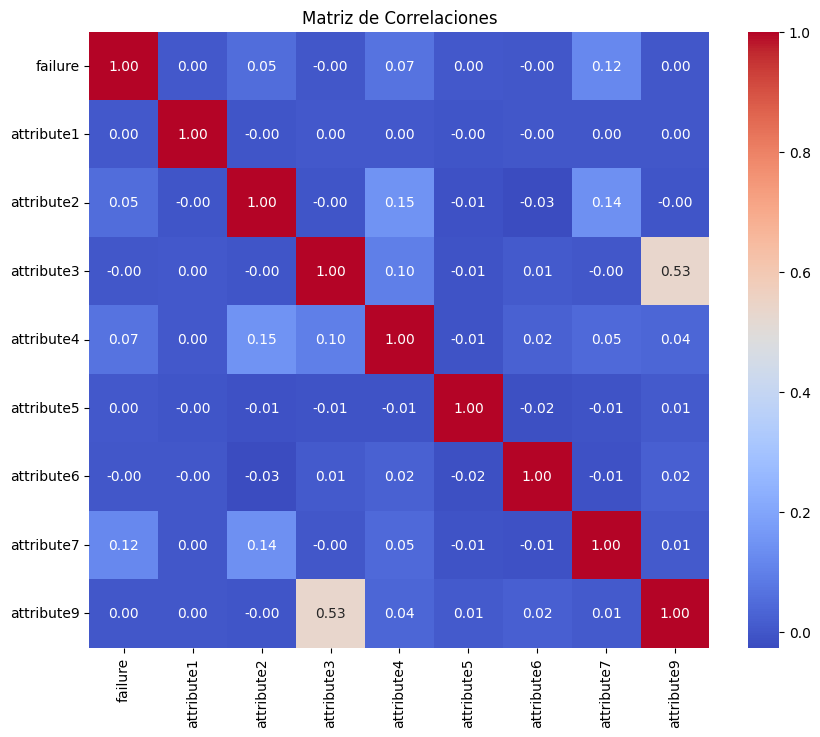

In [13]:
# Excluir columnas no numéricas
numeric_data = data.select_dtypes(include=['number'])

# Calcular la matriz de correlaciones
correlation_matrix = numeric_data.corr()

# Crear un heatmap de las correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlaciones')
plt.show()

Con la matriz de correlaciones queda evidenciado que no hay dependencia lineal entre failure y el resto de los atributos. Ya que la relación lineal más fuerte es con el atributo 7 y es de sólo 0.12, un valor muy bajo.  

Por este motivo la decisión del modelo tendrá que ser alguno que encuentre bien las relaciones no lineales (como Random Forest o XGBoost).

# 1e) ESCALADO Y SEPARACIÓN DE SET DE ENTRENAMIENTO Y PRUEBA

Dada la variabilidad de los datos y de los atributos, se decide trabajar con todos los atributos disponibles (excepto el que ya se había eliminado por estar duplicado).

In [14]:
features = data.drop(columns=['failure', 'date', 'device', ])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

X = scaled_features
y = data['failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  # random_state = x se usa para partir siempre de los mismos valores al inicializar las variables, x puede ser cualquier número pero se recomienda usar siempre el mismo.

print("Atributos seleccionados:", list(X.columns))

print("\nCantidad de datos de entrenamiento:", len(y_train))
print("Cantidad de datos de prueba:", len(y_test))

# Cantidad de ceros y unos en el conjunto de entrenamiento
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

print("\nDistribución en el conjunto de entrenamiento:")
print(f"Cantidad de 0: {train_counts[0]}")
print(f"Cantidad de 1: {train_counts[1]}")
print(f"Porcentaje de 1: {train_counts[1] / len(y_train) * 100:.4f}%")

print("\nDistribución en el conjunto de prueba:")
print(f"Cantidad de 0: {test_counts[0]}")
print(f"Cantidad de 1: {test_counts[1]}")
print(f"Porcentaje de 1: {test_counts[1] / len(y_test) * 100:.4f}%")

Atributos seleccionados: ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']

Cantidad de datos de entrenamiento: 99594
Cantidad de datos de prueba: 24899

Distribución en el conjunto de entrenamiento:
Cantidad de 0: 99508
Cantidad de 1: 86
Porcentaje de 1: 0.0864%

Distribución en el conjunto de prueba:
Cantidad de 0: 24879
Cantidad de 1: 20
Porcentaje de 1: 0.0803%


# **2) BÚSQUEDA DE UN ALGORITMO BASE DE PREDICCIÓN**

Para el flujo rápido de resolución se puede no ejecturar los subapartados del capítulo 2 (2a a 2e) ya que no hacen al modelo final seleccionado, si no a una búsqueda del mismo.  
Si se desea puede ejecutarse solamente el modelo seleccionado.   
El espíritu del mismo es mostrar la búsqueda del mejor modelo posible que luega se pueda optimizar

# 2a) MODELO BASE DE COMPARACIÓN: RANDOM FOREST POR DEFECTO

**AUC-ROC SCORE (Random Forest): 0.7184**


**Predominancia de atributos**  
Primera aproximación al modelo:  
Se utiliza Random Forest Classifier para verificar qué atributos tienen mayor influencia sobre 'failure' en este tipo de algoritmo.  
Se utiliza el método con sus hiperparámetros por defecto, dado que en esta primera instancia solo se trata de valorar los atributos.

AUC-SCORE (Random Forest): 0.7184


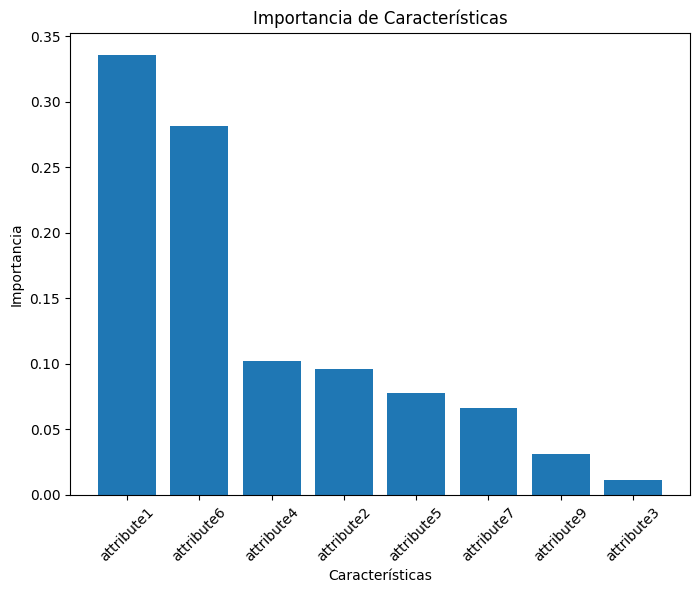

In [15]:
# Se entrena un modelo Random Forest convencional

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Se obtienen importancia de características
importances = rf.feature_importances_

importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Cálculo de AUC-SCORE
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]  # Probabilidades de la clase 1
auc_roc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"AUC-SCORE (Random Forest): {auc_roc_rf:.4f}")

# Se muestran las importancias
#print(importances_df)

plt.figure(figsize=(8, 6))
plt.bar(importances_df['Feature'], importances_df['Importance'])
plt.title('Importancia de Características')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45)
plt.show()

Reporte de Clasificación (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24879
           1       0.00      0.00      0.00        20

    accuracy                           1.00     24899
   macro avg       0.50      0.50      0.50     24899
weighted avg       1.00      1.00      1.00     24899

AUC-ROC (Random Forest): 0.7184


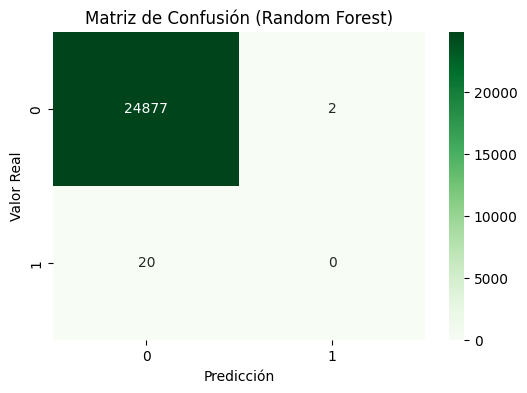

In [17]:
# Reporte de Clasificación
print("Reporte de Clasificación (Random Forest):")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# AUC-ROC SCORE
auc_roc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"AUC-ROC (Random Forest): {auc_roc_rf:.4f}")

# Matriz de Confusión
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusión (Random Forest)")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

# 2b) 2DO INTENTO: RANDOM FOREST APLICANDO SMOTE

**AUC-ROC SCORE (Random Forest) con SMOTE: 0.7314**

En este intento se aplica SMOTE para generar ejemplos sintéticos de la clase minoritaria (1) y así balancear el dataset de entrenamiento.

Atributos a utilizar: ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']

Distribución después de aplicar SMOTE:
0    99508
1    99508

AUC-ROC (Random Forest con SMOTE): 0.7314


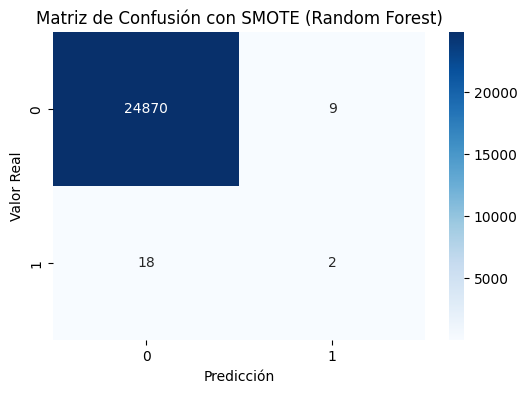

In [19]:
# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Atributos a utilizar:", list(X_train_smote.columns))

print("\nDistribución después de aplicar SMOTE:")
print(y_train_smote.value_counts().to_string(index=True, header=False))


# Reentrenar Random Forest con datos balanceados
rf_model_smote = RandomForestClassifier(random_state=0, n_estimators=100, class_weight=None)
rf_model_smote.fit(X_train_smote, y_train_smote)

# Predicciones con el modelo balanceado
y_pred_rf_smote = rf_model_smote.predict(X_test)
y_proba_rf_smote = rf_model_smote.predict_proba(X_test)[:, 1]

# AUC-ROC SCORE
auc_roc_rf = roc_auc_score(y_test, y_proba_rf_smote)
print(f"\nAUC-ROC (Random Forest con SMOTE): {auc_roc_rf:.4f}")

# Evaluar el modelo balanceado
#print("Reporte de Clasificación con SMOTE (Random Forest):")
#print(classification_report(y_test, y_pred_rf_smote))

# Matriz de Confusión
conf_matrix_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf_smote, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión con SMOTE (Random Forest)")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

# 2c) 3ER INTENTO: RANDOM FOREST CLASIFICANDO DISPOSITIVOS S,W,Z

**AUC-ROC SCORE (Random Forest) con SMOTE: S=0.86 ; W=0.76 ; Z=0.48**

Se analiza la posibilidad de que la primera letra de Device (S, W o Z) indique el tipo de dispositivo y se evalúa si tienen alguna influencia en el comportamiento.

In [20]:
# Copiar los datos y crear la columna con la primera letra del device
new_data = data.copy()
new_data['device_type'] = new_data['device'].str[0]

# Contar la cantidad de ceros y unos por tipo de dispositivo
failure_counts = new_data.groupby('device_type')['failure'].value_counts().unstack(fill_value=0)

# Renombrar las columnas
failure_counts.columns = ['cantidad_0', 'cantidad_1']

# Agregar la columna de proporción
failure_counts['proporcion_1_0_%'] = (failure_counts['cantidad_1'] / failure_counts['cantidad_0']) * 100
failure_counts.reset_index(inplace=True)
print(failure_counts)

  device_type  cantidad_0  cantidad_1  proporcion_1_0_%
0           S       54815          42          0.076621
1           W       43226          42          0.097164
2           Z       26346          22          0.083504


In [21]:
# Dividir los datos por tipo de dispositivo
device_types = new_data['device_type'].unique()

for device_type in device_types:
    print(f"\nEntrenando modelo para dispositivos tipo {device_type}...\n")

    # Filtrar datos para el tipo de dispositivo actual
    type_data = new_data[new_data['device_type'] == device_type]
    type_data = type_data.drop(columns=['device', 'date', 'device_type'])

    scaler = StandardScaler()
    scaled_type_data = scaler.fit_transform(type_data)
    scaled_type_data = pd.DataFrame(scaled_type_data, columns=type_data.columns)

    X = scaled_type_data.drop(columns=['failure'])
    y = type_data['failure']

    print("Atributos usados", list(X.columns))
    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Aplicar SMOTE al conjunto de entrenamiento
    smote = SMOTE(random_state=0)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print(f"Distribución de clases después de SMOTE para tipo {device_type}:")
    print(y_train_smote.value_counts().to_string(index=True, header=False))

    # Entrenar el modelo
    rf_model = RandomForestClassifier(random_state=0, n_estimators=100, class_weight='balanced')
    rf_model.fit(X_train_smote, y_train_smote)

    # Evaluar el modelo
    y_pred = rf_model.predict(X_test)
    y_proba = rf_model.predict_proba(X_test)[:, 1]

    auc_roc = roc_auc_score(y_test, y_proba)
    print(f"AUC-SCORE: {auc_roc:.4f}")

#    print(f"Reporte de Clasificación para tipo {device_type}:")
#    print(classification_report(y_test, y_pred, zero_division = 0))


Entrenando modelo para dispositivos tipo S...

Atributos usados ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']
Distribución de clases después de SMOTE para tipo S:
0    43854
1    43854
AUC-SCORE: 0.8656

Entrenando modelo para dispositivos tipo W...

Atributos usados ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']
Distribución de clases después de SMOTE para tipo W:
0    34581
1    34581
AUC-SCORE: 0.7672

Entrenando modelo para dispositivos tipo Z...

Atributos usados ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']
Distribución de clases después de SMOTE para tipo Z:
0    21077
1    21077
AUC-SCORE: 0.4862


# 2d) 4TO INTENTO: RANDOM FOREST CON DEVICE TYPE COMO VARIABLE

**AUC-ROC SCORE (Random Forest) con SMOTE = 0.7331**

Este método sigue la lógica del proceso anterior, verificar si la clasificación por tipo de artefacto (S, W y Z) ayudan a la detección de fallas. La diferencia con el anterior es que al tratarlas como una variable más, se pueden incorporar a los atributos y no es necesario dividir el dataset, trabajando con todos los datos juntos.

Este método no tuvo ninguna mejora respecto del Random Forest con los atributos originales.

In [22]:
# Convertir device_type a variables dummy
new_data2 = pd.get_dummies(new_data, columns=['device_type'], drop_first=True)

new_data2 = new_data2.drop(columns=['device', 'date'])

# Separar las columnas dummy (que no se deben escalar)
dummy_columns = ['device_type_W', 'device_type_Z']
numerical_columns = [col for col in new_data2.columns if col not in dummy_columns]

# Escalar solo las columnas numéricas
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(new_data2[numerical_columns])

# Reconstruir el DataFrame combinando las columnas escaladas y las dummy
scaled_new_data2 = pd.DataFrame(scaled_numerical, columns=numerical_columns)
scaled_new_data2[dummy_columns] = new_data2[dummy_columns].astype(int)

# Verificar los primeros resultados
scaled_new_data2.head()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,device_type_W,device_type_Z
0,-0.029192,1.323366,-0.047478,-0.053516,2.193895,-0.515757,1.485260,-0.039335,-0.028479,0,0
1,-0.029192,-0.865990,-0.073170,-0.037365,-0.076004,-0.515757,1.442255,-0.039335,-0.065047,0,0
2,-0.029192,0.722525,-0.073170,-0.053516,-0.076004,-0.139416,-0.229741,-0.039335,-0.065047,0,0
3,-0.029192,-0.605934,-0.073170,-0.053516,-0.076004,-0.515757,1.512975,-0.039335,-0.065047,0,0
4,-0.029192,0.192778,-0.073170,-0.053516,-0.076004,0.048754,0.534538,-0.039335,-0.049375,0,0


In [23]:
# Preparar X e y
X = scaled_new_data2.drop(columns=['failure']) #, 'device_type_W', 'device_type_Z'])
y = new_data2['failure']
print("Atributos usados", list(X.columns))
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Entrenar Random Forest con datos balanceados
rf_model = RandomForestClassifier(random_state=0, n_estimators=100, class_weight=None)
rf_model.fit(X_train_smote, y_train_smote)

# Evaluar el modelo
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

auc_roc = roc_auc_score(y_test, y_proba)
print(f"\nAUC-ROC: {auc_roc:.4f}")
#print("Reporte de Clasificación con device_type como característica y SMOTE:")
#print(classification_report(y_test, y_pred, zero_division=0))

Atributos usados ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9', 'device_type_W', 'device_type_Z']

AUC-ROC: 0.7331


# 2e) 5TO INTENTO: XGBOOST CLASSIFIER

**AUC-ROC SCORE (XGBOOST: 0.7647)**

El XGBoost Classifier es un algoritmo que suele ser rápido, eficiente y preciso, ya que optimiza el proceso de boosting utilizando árboles de decisión secuenciales, donde cada árbol corrige los errores del anterior.  
A pesar de esto su score inicial no fue superior al Random Forest.

In [24]:
# Preparar los datos
data_prepared = data.copy().drop(columns=['date', 'device'])
X = data_prepared.drop(columns=['failure'])
y = data_prepared['failure']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Escalar las características numéricas

print("Atributos a utilizar: ", list(X.columns))

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, stratify=y)

# Crear el modelo XGBoost sin scale_pos_weight
model = XGBClassifier(random_state=0, eval_metric='auc')
#model = XGBClassifier(random_state=0, scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

# Entrenar el modelo
model.fit(X_train, y_train);


Atributos a utilizar:  ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']


In [25]:
# Hacer predicciones
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

auc_roc = roc_auc_score(y_test, y_proba)
print(f"AUC-SCORE: {auc_roc:.4f}")

AUC-SCORE: 0.7647


# **MODELO SELECCIONADO: RANDOM FOREST CON INCORPORACION DE DELTAS**

**AUC-ROC SCORE (Random Forest): 0.8595**

El modelo que se seleccionó luego de varios intentos con diferentes modelos y estrategias (algunas se omitieron) es este de Random Forest con la incorporación de nuevos atributos ("Deltas").

Estos "Deltas" que se incorporaron, son justamente variables calculadas como la diferencia del valor de un atributo para un día específico y el mismo atributo para el día anterior, siempre considerando el mismo artefacto.

Por ejemplo: si tomamos el artefacto S1F01085, la variable "attribute1_delta" correspondiente al día 2/1 (2015-01-02) es igual al valor de atrribute1 de ese día menos el valor de attribute1 del día anterior (2015-01-01)

La lógica de esta incorporación de atributos es evaluar la posibilidad de que no sea necesariamente el valor absoluto de una variable lo que haga que un artefacto falle, si no el propio hecho de que haya variado.

**Cálculo y agregado de los deltas**  
Se agregaron 4 columnas con los deltas de 4 atributos (1, 2, 4 y 6). Se seleccionaron estos atributos porque fueron los que mayor influencia presentaron en el análisis de influencias de Random Forest.

Se creó una nueva tabla de valores llamda 'data_with_deltas' como una copia de la original a la que se agregaron estas 4 columnas. a continuación se muestran los primeros 10 registros.



In [26]:
data_with_deltas = data.copy().sort_values(by=['device', 'date']) # Se ordenan los datos por 'device' y 'date'

for col in [ 'attribute1', 'attribute2', 'attribute4', 'attribute6']:
    data_with_deltas[f'{col}_delta'] = data.groupby('device')[col].diff()    #Se calculan de las diferencias entre valores consecutivos de las columnas agrupadas según device

delta_columns = [ 'attribute1_delta', 'attribute2_delta','attribute4_delta','attribute6_delta']
data_with_deltas[delta_columns] = data_with_deltas[delta_columns].fillna(0)   # Se reemplaza NaN por 0 en los deltas, correspondientes a los primeros valores de cada secuencia

# Ver los primeros resultados para verificar
data_with_deltas.head(10)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,attribute1_delta,attribute2_delta,attribute4_delta,attribute6_delta
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,0.0,0.0,0.0,0.0
1163,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,7,-213979808.0,0.0,0.0,0.0
2326,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,7,122366504.0,0.0,0.0,0.0
3489,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,7,4055856.0,0.0,0.0,1.0
4651,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,7,-30679776.0,0.0,0.0,675.0
5812,2015-01-06,S1F01085,0,128832128,56,0,52,6,409404,0,7,31438680.0,0.0,0.0,1290.0
78172,2015-05-06,S1F013BB,0,14533968,0,0,0,5,688952,0,0,0.0,0.0,0.0,0.0
78576,2015-05-07,S1F013BB,0,46202296,0,0,0,5,688952,0,0,31668328.0,0.0,0.0,0.0
78981,2015-05-08,S1F013BB,0,214383720,0,0,0,5,688964,0,0,168181424.0,0.0,0.0,12.0
79385,2015-05-09,S1F013BB,0,243346080,0,0,0,5,689035,0,0,28962360.0,0.0,0.0,71.0


Luego de agregar las columnas necesarias, se toman todas las columnas de atributos (X), que son los 8 atributos y los 4 deltas.  
Se separan en conjunto de entrenamiento y prueba.  
Se aplica SMOTE para balancear las clases en el entrenamiento.  
Se entrena el modelo y se colocan los resultados del AUCROC Score.   

In [27]:
# Separar características y variable objetivo
X = data_with_deltas.drop(columns=['failure', 'date', 'device'])  # Eliminamos columnas no relevantes para el modelo
y = data_with_deltas['failure']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Escalar características numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Atributos usados",list(X.columns))

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


Atributos usados ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9', 'attribute1_delta', 'attribute2_delta', 'attribute4_delta', 'attribute6_delta']


In [28]:
# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(random_state=0, n_estimators=100, class_weight=None)
rf_model.fit(X_train_smote, y_train_smote)

# Hacer predicciones
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_proba)
print(f"\nAUC-ROC (Random Forest): {auc_roc:.4f}")


AUC-ROC (Random Forest): 0.8595


# **3) SELECCIÓN DE HIPERPARÁMETROS PARA EL MODELO SELECCIONADO**

**Este item puede omitirse si se desea una ejecución del esqueleto principal del programa.**

Con el modelo de mejor score seleccionado, se procede a refinarlo seleccionando los hiperparámetros que mejor se ajusten al dataset, para mejorar aún más la eficacia del mismo.

Para eso se utiliza el método RandomizedSearch, que selecciona aleatoriamente un número fijo de combinaciones dentro de un espacio definido de los hiperparámetros a evaluar.  

Este es un método que logra buenos resultados sin tanto costo computacional, y para el modelo seleccionado logró la mejora del AUC-ROC Score que estaba en 0,8595 a 0,9377 (aplicando SMOTE en ambos casos).   

Los mejores hiperparámetros fueron: 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None, 'class_weight': 'balanced'

In [30]:
# 5. Ajuste de hiperparámetros con RandomizedSearch
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

def log_progress(out, params, scores, elapsed_time):
    """Escribe el progreso de RandomizedSearch incluyendo el tiempo tomado."""
    with open(out, 'a') as f:
        f.write(f"Params: {params}, AUC: {scores}, Time: {elapsed_time:.2f} seconds\n")

# Archivo para guardar el progreso
progress_file = "random_search_progress.txt"

# Inicializar RandomizedSearch
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=0), param_grid, n_iter=20, cv=3, scoring='roc_auc', n_jobs=-1, random_state=0)

# Ajustar modelo y registrar progreso
try:
    print("Iniciando búsqueda de hiperparámetros con RandomizedSearch...")
    start_time = time.time()
    random_search.fit(X_train_scaled, y_train)
    elapsed_time = time.time() - start_time
    for i, params in enumerate(random_search.cv_results_['params']):
        auc = random_search.cv_results_['mean_test_score'][i]
        print(f"Combinación {i + 1}/{len(random_search.cv_results_['params'])}: {params}, AUC: {auc}, Time: {elapsed_time:.2f} seconds")
        log_progress(progress_file, params, auc, elapsed_time)
except KeyboardInterrupt:
    print("Interrumpido, guardando progreso...")
    joblib.dump(random_search, 'random_search_partial.pkl')

# Mejor modelo encontrado
best_model = random_search.best_estimator_
print("Mejores hiperparámetros:", random_search.best_params_)

Iniciando búsqueda de hiperparámetros con RandomizedSearch...
Combinación 1/20: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': 'balanced'}, AUC: 0.8157032144319157, Time: 162.75 seconds
Combinación 2/20: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'class_weight': 'balanced'}, AUC: 0.834379053799552, Time: 162.75 seconds
Combinación 3/20: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20, 'class_weight': 'balanced'}, AUC: 0.8335708519342937, Time: 162.75 seconds
Combinación 4/20: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None, 'class_weight': 'balanced'}, AUC: 0.8542284410691604, Time: 162.75 seconds
Combinación 5/20: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'class_weight': 'balanced'}, AUC: 0.7467856871054201, Time: 162.75 seconds
Combinación 6/20: {'n_estimators': 100, 

# **4) PERFORMANCE DEL MODELO SELECCIONADO**

AUC-ROC SCORE (RANDOM FOREST WITH DELTAS + SMOTE + AJUSTE DE HIPERPARÁMETROS) = 0.9377

En este apartado se realiza el entrenamiento final del mejor modelo encontrado, con todos los parámetros ajustados.

Posteriormente se realizan gráficos de:  
*   Precisión vs umbral
*   Recall vs umbral
*   Distribución de valores reales vs probabilidades predichas  

 Con todo esto se determina el mejor umbral de decisión para obtener el mínimo costo y se evalúa la performance del mismo.

In [31]:
# Aplicar SMOTE para generar nuevas muestras
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Entrenar el modelo con datos balanceados
best_model_smote = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=4,
    max_depth=None,
    class_weight='balanced',
    random_state=0
)
best_model_smote.fit(X_train_resampled, y_train_resampled)

# Evaluar el modelo en el conjunto de prueba
y_pred_smote = best_model_smote.predict(X_test_scaled)
y_pred_proba_smote = best_model_smote.predict_proba(X_test_scaled)[:, 1]

# Métricas de evaluación
#print("Classification Report (con SMOTE):")
#print(classification_report(y_test, y_pred_smote))
print("AUC Score (con SMOTE):", roc_auc_score(y_test, y_pred_proba_smote))


AUC Score (con SMOTE): 0.936549408733668


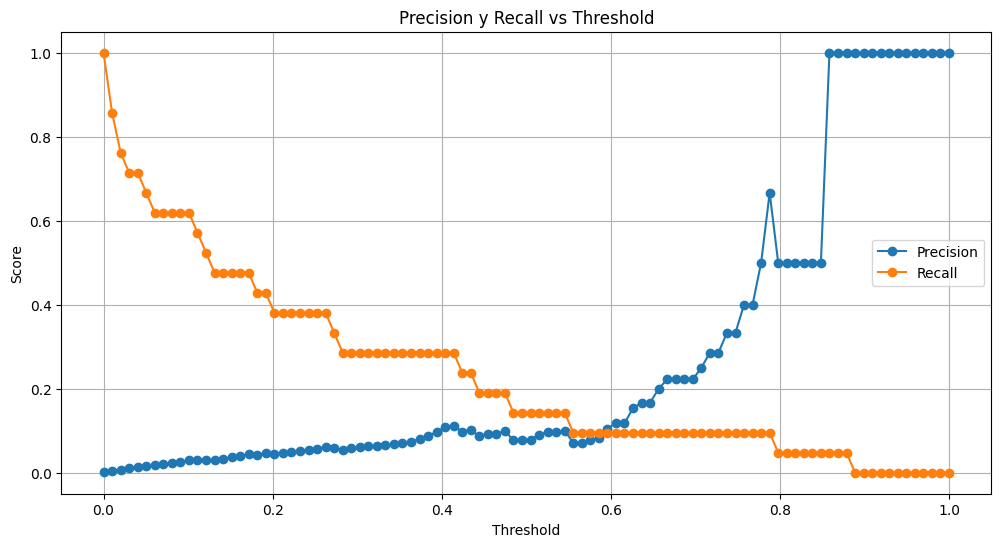

Mejor valor en la función de costos, C= 20.5


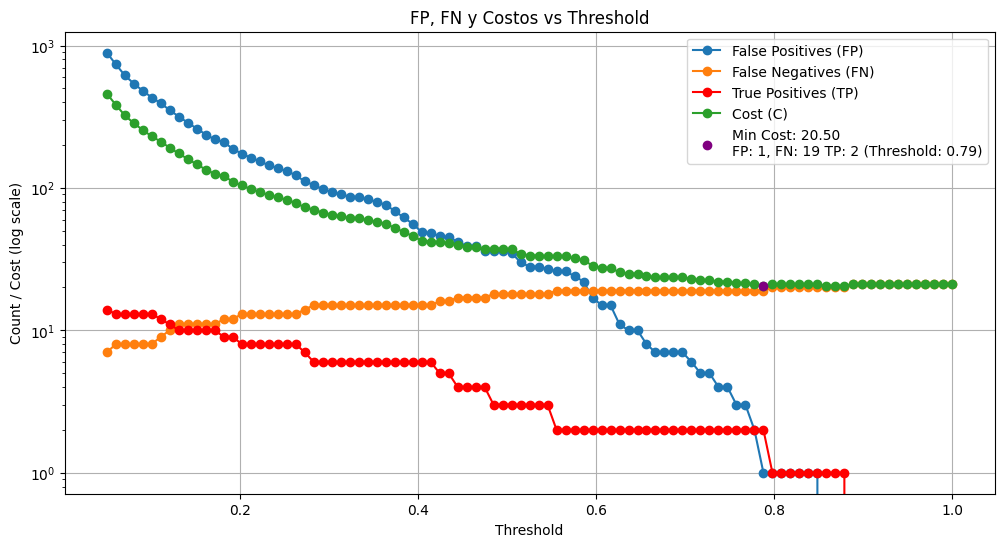

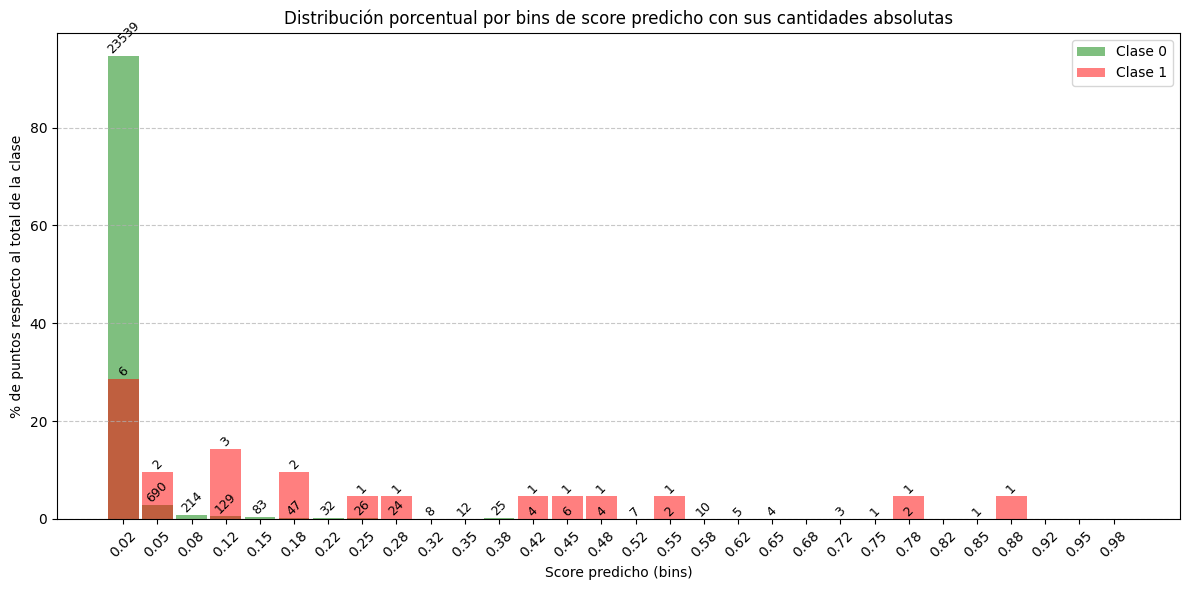

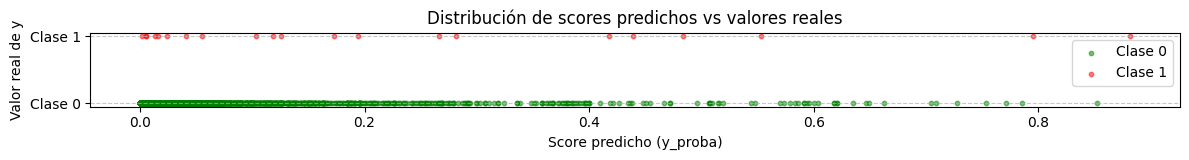

In [32]:
# Generar valores de Precision y Recall para distintos thresholds
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []

# Obtener probabilidades de predicción
y_pred_proba_smote = best_model_smote.predict_proba(X_test_scaled)[:, 1]

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_smote >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred_threshold, zero_division=1))
    recalls.append(recall_score(y_test, y_pred_threshold, zero_division=0))

# Graficar Precision vs Threshold y Recall vs Threshold
plt.figure(figsize=(12, 6))

# Precision vs Threshold
plt.plot(thresholds, precisions, label='Precision', linestyle='-', marker='o')
plt.plot(thresholds, recalls, label='Recall', linestyle='-', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision y Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Calcular FP, FN, TP, TN y costos para distintos thresholds
thresholds = np.linspace(0.05, 1, 95)
false_positives = []
false_negatives = []
true_positives = []
true_negatives = []
costs = []

# Obtener probabilidades de predicción
y_pred_proba_smote = best_model_smote.predict_proba(X_test_scaled)[:, 1]

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_smote >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()

    # Guardar valores
    true_positives.append(tp)
    true_negatives.append(tn)
    false_positives.append(fp)
    false_negatives.append(fn)

    # Calcular costo
    cost = fp * 0.5 + fn * 1 + tp *0.5
    costs.append(cost)

# Encontrar el índice del menor costo
min_cost_index = np.argmin(costs)
min_cost_threshold = thresholds[min_cost_index]
min_cost_value = costs[min_cost_index]
min_cost_fp = false_positives[min_cost_index]
min_cost_fn = false_negatives[min_cost_index]
min_cost_tp = true_positives[min_cost_index]
min_cost_tn = true_negatives[min_cost_index]


print("Mejor valor en la función de costos, C=", min_cost_value)
# Graficar FP, FN y Costos vs Threshold
plt.figure(figsize=(12, 6))

# FP, FN y Costos
plt.plot(thresholds, false_positives, label='False Positives (FP)', linestyle='-', marker='o')
plt.plot(thresholds, false_negatives, label='False Negatives (FN)', linestyle='-', marker='o')
plt.plot(thresholds, true_positives, label='True Positives (TP)', linestyle='-', marker='o', color= 'red')
plt.plot(thresholds, costs, label='Cost (C)', linestyle='-', marker='o')

# Marcar el punto de menor costo
plt.scatter(min_cost_threshold, min_cost_value, color='purple',
            label=f'Min Cost: {min_cost_value:.2f}\nFP: {min_cost_fp}, FN: {min_cost_fn} TP: {min_cost_tp} (Threshold: {min_cost_threshold:.2f})', zorder=5)

plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Threshold')
plt.ylabel('Count / Cost (log scale)')
plt.title('FP, FN y Costos vs Threshold')
plt.legend()
plt.grid()
plt.show()


# Definir los bins para los scores
bins = np.linspace(0, 1, 31)  # Dividimos en 30 bins
bin_centers = (bins[:-1] + bins[1:]) / 2  # Centros de los bins

# Calcular las probabilidades predichas y los valores reales
y_pred_proba = best_model_smote.predict_proba(X_test_scaled)[:, 1]  # Probabilidades predichas
y_actual = y_test.values  # Valores reales

# Crear un DataFrame para agrupar los datos
data_proba = pd.DataFrame({'y_proba': y_pred_proba, 'y_actual': y_actual})
data_proba['bin'] = pd.cut(data_proba['y_proba'], bins=bins, labels=bin_centers, include_lowest=True)

# Calcular el % por bin respecto al total de ceros y unos del test_set
class_0_total = len(data_proba[data_proba['y_actual'] == 0])
class_1_total = len(data_proba[data_proba['y_actual'] == 1])

percentages = data_proba.groupby(['bin', 'y_actual'], observed=False).size().unstack(fill_value=0)
percentages[0] = (percentages[0] / class_0_total) * 100  # % de ceros respecto al total de ceros
percentages[1] = (percentages[1] / class_1_total) * 100  # % de unos respecto al total de unos

# Cantidades absolutas por bin
absolute_counts = data_proba.groupby(['bin', 'y_actual'], observed=False).size().unstack(fill_value=0)

# Graficar el resultado
plt.figure(figsize=(12, 6))
bars_0 = plt.bar(percentages.index, percentages[0], width=0.03, color='green', alpha=0.5, label='Clase 0')
bars_1 = plt.bar(percentages.index, percentages[1], width=0.03, color='red', alpha=0.5, label='Clase 1')

# Agregar etiquetas encima de las barras
for bar, count in zip(bars_0, absolute_counts[0]):
    if count > 0:  # Solo agregar si hay valores
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(count)}',
                 ha='center', va='bottom', fontsize=9, color='black', rotation=45)
for bar, count in zip(bars_1, absolute_counts[1]):
    if count > 0:  # Solo agregar si hay valores
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(count)}',
                 ha='center', va='bottom', fontsize=9, color='black', rotation=45)

# Configuración del gráfico
plt.xlabel('Score predicho (bins)')
plt.ylabel('% de puntos respecto al total de la clase')
plt.title('Distribución porcentual por bins de score predicho con sus cantidades absolutas')
#plt.yscale('log')
plt.xticks(ticks=bin_centers, labels=[f"{round(c, 2)}" for c in bin_centers], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Crear el gráfico de puntos
plt.figure(figsize=(12, 1.7))

# Clase 0
plt.scatter(
    data_proba[data_proba['y_actual'] == 0]['y_proba'],
    data_proba[data_proba['y_actual'] == 0]['y_actual'],
    color='green', alpha=0.5, label='Clase 0', s=10
)

# Clase 1
plt.scatter(
    data_proba[data_proba['y_actual'] == 1]['y_proba'],
    data_proba[data_proba['y_actual'] == 1]['y_actual'],
    color='red', alpha=0.5, label='Clase 1', s=10
)

# Configuración del gráfico
plt.xlabel('Score predicho (y_proba)')
plt.ylabel('Valor real de y')
plt.title('Distribución de scores predichos vs valores reales')
plt.yticks([0, 1], labels=['Clase 0', 'Clase 1'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

#**5) CONCLUSIONES**

El modelo demostró tener un buen AUC-ROC Score (0,937), es decir que tiene una muy alta probabilidad de, al tomar un punto de clase 0 y un punto de clase 1 al azar, calificar al 1 mayor que al cero.  
El AUC_ROC score nos da idea de una buena performance a pesar del desbalance (99,9% de los puntos pertenecen a la clase 0)

Recordemos los costos asociados a los diferentes tipos de predicciones para evaluar el umbral definido:

*   C(TN) = 0 Predecir que no hay falla y que efectivamente no falle.  
*   C(FN) = 1 Predecir que no hay falla y que al artefacto termine fallando, esto generaría un mantenimiento correctivo de 1.  
*   C(FP) = 0,5 Predecir que el artefacto va a fallar y repararlo (aunque en realidad no iba a fallar).
*   C(TP) = 0,5 Predecir que el artefacto va a fallar, repararlo y que efectivamente estuviera por fallar.

Dado que estamos ante una altísima cantidad de casos de clase 0 (no falla), el mejor umbral para la función de costos es un umbral elevado (0,79).  
Esto se puede observar bien en los dos últimos gráficos: Si tomamos un umbral=1 y comenzamos a bajar, luego del 2do caso de falla (de clase 1, en el umbral de 0,82) que me encuentro, hasta llegar al 3er caso positivo (umbral=0,55) hay 24 casos de clase 0, que tendría que calificar como False Positives en caso de bajar el umbral, por lo que sumaría 11,5 puntos a la función de costos si quisiera tener ese umbral.  

Esto hace que el modelo tome la mayoría de los casos de clase 1 como False Negatives, es decir "prefiere arriesgar a romper algún que otro artefacto y tener que repararlo a un costo de 1 que reparar demasiados artefactos que no lo necesitaban".   
